# Project: Volatility Forecasting for NVDA using GARCH family models.

## Introduction

1. What is my objective?
    - Analyze the volatility of NVDA using GARCH family models (GARCH, EGARCH, TGARCH, IGARCH).
    - Identify which model best captures stylized fact (volatility clustering, fat tails, leverage effects and etc).
    - Compare short-term (1-day ahead) volatility forecasts using RMSE on out-of-sample data.

2. What business get?
    - Anticipating volatility helps improve portfolio weight allocation.
    - Volatility forecasts can be used as signals to support stock recommendations.

3. Understand the dataset
    - Source: NVDA (NVIDIA Corporation) daily stock prices were downloaded from Yahoo Finance using the yfinance API.
    - Period: 
        - In-sample: 2015-01-01 to 2024-12-31
        - Out-of-sample: 2025-01-01 to 2025-10-02
    - Frequency: Daily closing prices (adjusted for dividends and stock splits).
    - About NVDA:
        - NVIDIA is a leading U.S. technology stock in the semiconductor industry, known for its GPUs widely used in gaming, AI, data centers, and autonomous vehicles.
        - The stock is part of the Nasdaq-100 index and is considered a high-beta, high-volatility growth stock.
        - Especially after 2020 (post-COVID), NVDA experienced explosive growth driven by AI demand, leading to higher volatility compared to many traditional sectors.
    - Why NVDA is suitable for GARCH family models:
        - Daily returns show heteroskedasticity (ARCH effect) even after fitting ARIMA to remove autocorrelation.
        - This makes NVDA a strong candidate for volatility modeling with GARCH, EGARCH, TGARCH, IGARCH to capture persistence, fat tails, and possible leverage effect.

## Plans

1. Dowload and Explore data
2. GARCH Modeling
3. Family GARCH Forecasting
4. Result
5. Conclusion

## 0. Setup basics library & data

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch
from statsmodels.stats.diagnostic import acorr_ljungbox
from arch.univariate import ConstantMean, RiskMetrics2006, StudentsT, GeneralizedError

In [3]:
nvda = yf.download("NVDA", start="2015-01-01", interval="1d", auto_adjust=True)
nvda['r'] = np.log(nvda['Close']).diff().dropna()
nvda = nvda.dropna()

# Split data
train = nvda.loc["2015-01-01":"2024-12-31"].copy()
test  = nvda.loc["2025-01-01":].copy()

[*********************100%***********************]  1 of 1 completed


## 1. Explore data

### 1.1 View data
- You can see that NVDA all time high is 188.139 and best return in one day is 26.08%, as 02/10/2568

In [ ]:
# Check basic statistic
nvda.describe()

Price,Close,High,Low,Open,Volume,r
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,
count,2702.000000,2702.000000,2702.000000,2702.000000,2.702000e+03,2702.000000
mean,29.253693,29.753625,28.687640,29.243754,4.515127e+08,0.002206
std,44.530119,45.235627,43.713961,44.525096,2.531692e+08,0.030615
min,0.459282,0.467921,0.454483,0.463602,5.244800e+07,-0.207712
25%,3.702681,3.793865,3.631850,3.728045,2.879000e+08,-0.012479
50%,8.456651,8.534106,7.905252,8.236488,4.001260e+08,0.002668
75%,27.067514,27.467537,26.574182,27.045278,5.454242e+08,0.017585
max,187.240005,188.139999,183.899994,185.240005,3.692928e+09,0.260877


In [ ]:
# Check datatype
nvda.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2702 entries, 2015-01-05 to 2025-10-01
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, NVDA)   2702 non-null   float64
 1   (High, NVDA)    2702 non-null   float64
 2   (Low, NVDA)     2702 non-null   float64
 3   (Open, NVDA)    2702 non-null   float64
 4   (Volume, NVDA)  2702 non-null   int64  
 5   (r, )           2702 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 212.3 KB


### 1.2 Plot
- From the daily return, it appears that there is no clear seasonality. There is no need to adjust the seasonality unless using intraday data.
- The stock price was "sideways" from 2015 to 2019.
- After COVID-19, NVDA's price began to surge, particularly in 2023–2024, indicating a structural break/regime shift.
- The return graph (bottom) clearly shows periods of sustained strong returns (e.g., during the 2020 COVID crash, the 2022 Fed rate hike, and the 2023 rally).
- This is the "stylized fact" that the GARCH family is designed to address.
- After 2023, volatility will not only be temporary but persistent.

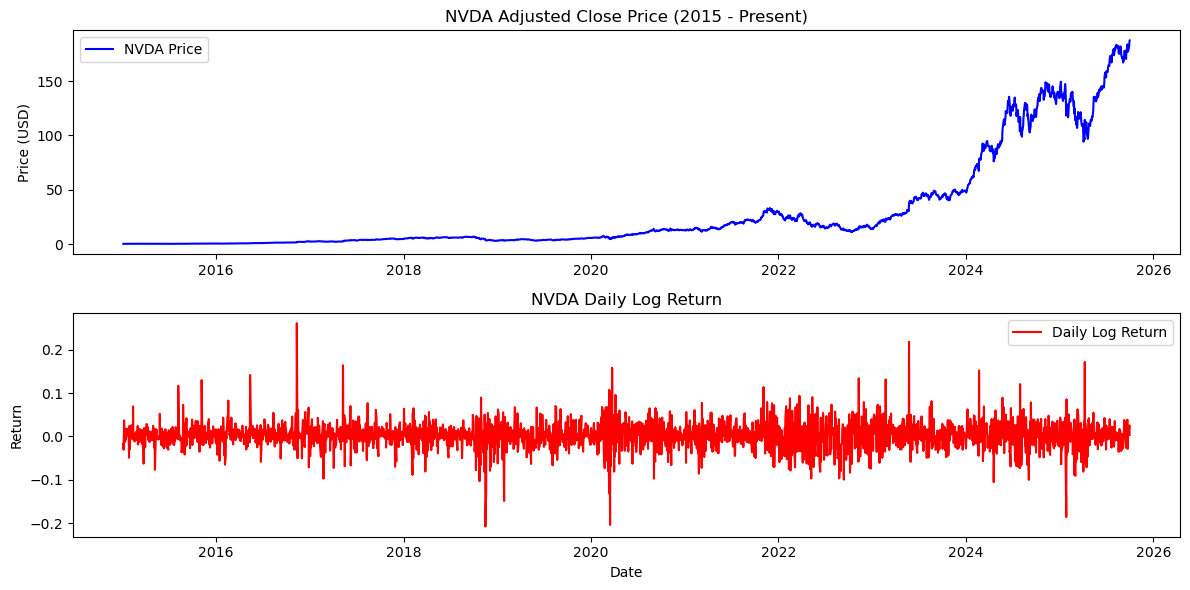

In [8]:
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(nvda['Close'], label="NVDA Price", color="blue")
plt.title("NVDA Adjusted Close Price (2015 - Present)")
plt.ylabel("Price (USD)")
plt.legend()

plt.subplot(2,1,2)
plt.plot(nvda['r'], label="Daily Log Return", color="red")
plt.title("NVDA Daily Log Return")
plt.ylabel("Return")
plt.xlabel("Date")
plt.legend()

plt.tight_layout()
plt.show()

### 1.3 Data distribution
- The distribution is narrow in the center but has long tails on both sides (fat tails). 
- It is not a normal distribution because it has a high peak and fat tails.
- A heavy-tailed distribution (Student-t, GED) should be used in GARCH.
- Volatility clustering and fat tails confirm the appropriateness of using GARCH family models.

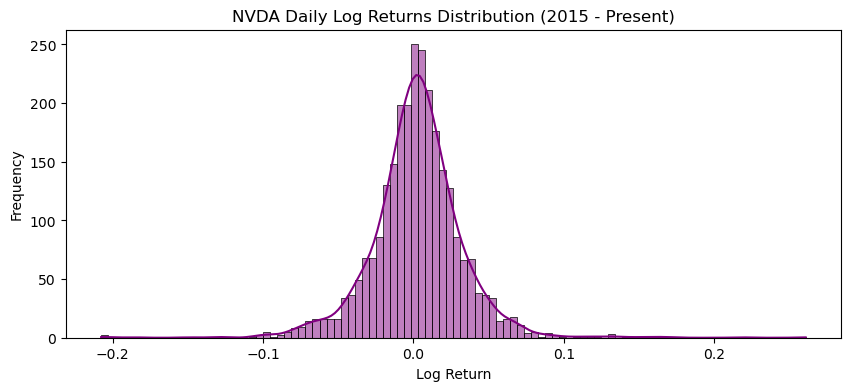

In [12]:
plt.figure(figsize=(10,4))
sns.histplot(nvda['r'].dropna(), bins=100, kde=True, color='purple')
plt.title("NVDA Daily Log Returns Distribution (2015 - Present)")
plt.xlabel("Log Return")
plt.ylabel("Frequency")
plt.show()

## 2. GARCH Modeling

### 2.1 Check Stationary
- ADF Statistic (-18.539) < Critical Value at 1% (-3.432)
- P-value is almost zero (much less than 0.05)
- Null hypothesis rejected (H₀: unit root/non-stationary)
- Meaning: Data have constant mean and variance, no significant trend or seasonality

In [16]:
adftest = adfuller(nvda["r"])

print(f'ADF Statistic: {adftest[0]}')
print(f'p-value: {adftest[1]}')
print(f'Critical Values: {adftest[4]}')

ADF Statistic: -18.539801859299086
p-value: 2.0983178072176254e-30
Critical Values: {'1%': -3.4327796740267975, '5%': -2.862613451060739, '10%': -2.56734143381123}


### 2.2 Choose lag
- There is a high correlation both ACF and PACF on lag 1
- So I will use AR(1) from PACF and MA(1) from ACF

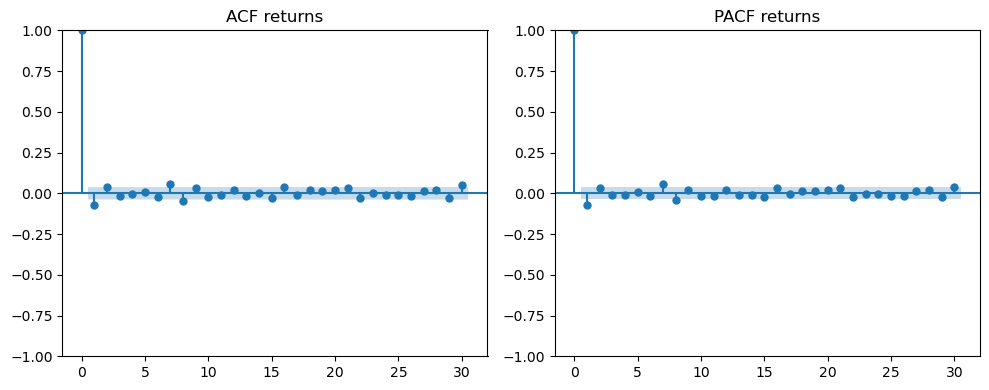

In [ ]:
r = (nvda['r'].dropna())

# Watch ACF/PACF of log return to see dynamic for choosing lag
fig, ax = plt.subplots(1,2, figsize=(10,4))
plot_acf(r, lags=30, ax=ax[0]); ax[0].set_title("ACF returns")
plot_pacf(r, lags=30, ax=ax[1]); ax[1].set_title("PACF returns")
plt.tight_layout(); plt.show()

### 2.3 Check Autocorrelation
- Not reject Null hypothesis (P-value > 0.05) 
- Which means there is no autocorrelation.

In [ ]:
# ARIMA(1,0,1)
arima1 = sm.tsa.ARIMA(r, order=(1,0,1)).fit()
resid_mean = arima1.resid

# Use Ljung–Box to see residual if there any serial correlation.
print(acorr_ljungbox(resid_mean, lags=[1,2,3,4,5], return_df=True))

    lb_stat  lb_pvalue
1  0.000006   0.998060
2  0.011170   0.994430
3  0.012024   0.999651
4  0.529113   0.970606
5  0.621532   0.986996


c:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


### 2.4 Check ARCH effects
- Reject Null hypothesis (LM-value < 0.05)
- Which means there is ARCH effect, so we can use ARCH or GARCH.
- There is peak in lag 1 both ACF, PACF which mean we can use GARCH(1,1).

{'LM pvalue': 1.841622643118219e-11, 'F pvalue': 1.2945973415943102e-11}


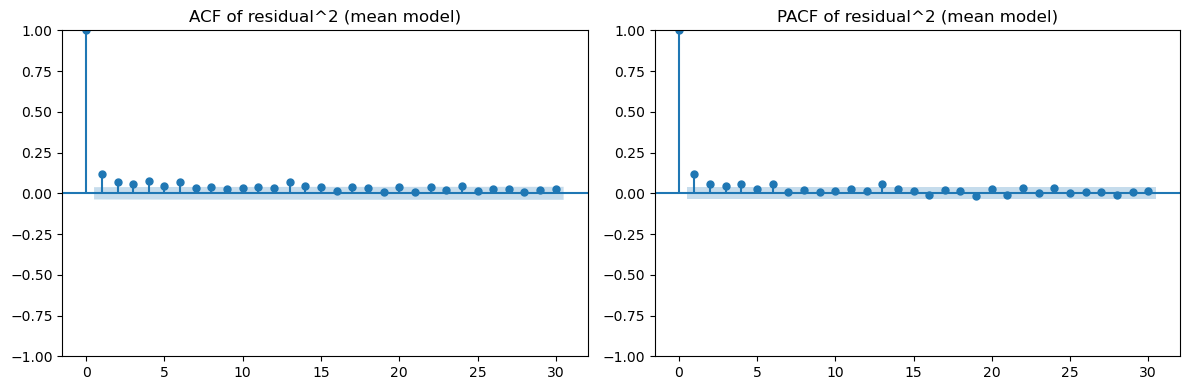

In [ ]:
# H0: No ARCH
lm_stat, lm_pvalue, f_stat, f_pvalue = het_arch(resid_mean, nlags=10)
print({"LM pvalue": lm_pvalue, "F pvalue": f_pvalue})

# Correlogram of residual^2 for choose GARCH lags
fig, ax = plt.subplots(1, 2, figsize=(12,4))
plot_acf(resid_mean**2, lags=30, ax=ax[0])
ax[0].set_title("ACF of residual^2 (mean model)")
plot_pacf(resid_mean**2, lags=30, ax=ax[1], method="yw")
ax[1].set_title("PACF of residual^2 (mean model)")

plt.tight_layout()
plt.show()

### 2.5 GARCH Modeling, t-distribution
- Accept H0, there is no autocorrelation.
- There is no ARCH effect in GARCH model which means our model keep all dynamic.

In [54]:
# GARCH(1,1)
# Scale to % for stability of varaince estimate.
r_pct = r*100

am_garch_t = arch_model(r_pct, vol='GARCH', p=1, q=1, mean='Constant', dist='t')
res_garch_t = am_garch_t.fit(disp='off')
print(res_garch_t.summary())

aic1 = res_garch_t.aic
bic1 = res_garch_t.bic
log_likelihood1 = res_garch_t.loglikelihood

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            r   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -6495.52
Distribution:      Standardized Student's t   AIC:                           13001.0
Method:                  Maximum Likelihood   BIC:                           13030.5
                                              No. Observations:                 2702
Date:                      Thu, Oct 02 2025   Df Residuals:                     2701
Time:                              22:27:34   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0

In [55]:
# Hypothesis test after fit GARCH model
std_resid = res_garch_t.std_resid

# Use Ljung–Box to check if there autocorrelation
# Reject H0, there is no autocorrelation
print(acorr_ljungbox(std_resid, lags=[1,2,3,4,5], return_df=True))

# Check ARCH effect
# There is no ARCH effect in GARCH model which means our model keep all dynamic.
lm_stat2, lm_pvalue2, _, _ = het_arch(std_resid, nlags=10)
print({"Post-GARCH LM pvalue": lm_pvalue2})

    lb_stat  lb_pvalue
1  2.270795   0.131832
2  2.428554   0.296925
3  2.598229   0.457800
4  2.627340   0.621988
5  2.633804   0.756223
{'Post-GARCH LM pvalue': 0.9312525177996864}


### 2.6 GARCH Modeling, ged distribution
- Accept H0, there is no autocorrelation.
- There is no ARCH effect in GARCH model which means our model keep all dynamic.

In [56]:
am_garch_t = arch_model(r_pct, vol='GARCH', p=1, q=1, mean='Constant', dist='ged')
res_garch_t = am_garch_t.fit(disp='off')
print(res_garch_t.summary())

aic2 = res_garch_t.aic
bic2 = res_garch_t.bic
log_likelihood2 = res_garch_t.loglikelihood

                           Constant Mean - GARCH Model Results                            
Dep. Variable:                                  r   R-squared:                       0.000
Mean Model:                         Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                  GARCH   Log-Likelihood:               -6523.34
Distribution:      Generalized Error Distribution   AIC:                           13056.7
Method:                        Maximum Likelihood   BIC:                           13086.2
                                                    No. Observations:                 2702
Date:                            Thu, Oct 02 2025   Df Residuals:                     2701
Time:                                    22:27:40   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
-----------------------------------

In [ ]:
# Hypothesis test after fit GARCH model
std_resid = res_garch_t.std_resid

# Use Ljung–Box to check if there autocorrelation
# Accept H0, there is no autocorrelation
print(acorr_ljungbox(std_resid, lags=[1,2,3,4,5], return_df=True))

# Check ARCH effect
# There is no ARCH effect in GARCH model which means our model keep all dynamic.
lm_stat3, lm_pvalue3, _, _ = het_arch(std_resid, nlags=10)
print({"Post-GARCH LM pvalue": lm_pvalue3})

    lb_stat  lb_pvalue
1  2.171613   0.140579
2  2.326600   0.312453
3  2.516659   0.472288
4  2.538139   0.637820
5  2.544608   0.769763
{'Post-GARCH LM pvalue': 0.8953692349659822}


### 2.7 What difference between using "t" and "ged" distribution
- We can see that using "t-distribution" is more appropriate than "ged distribution" in GARCH(1,1).
- Based on all three lag criteria selection.
- AIC/BIC: Lower is better
- Log-Likelihood: Higher is better / Less negative
- But in this project we will test both.

In [58]:
print(f"t_aic = {aic1}, t_bic = {bic1}, t_log_likelihood = {log_likelihood1}")
print(f"ged_aic = {aic2}, ged_bic = {bic2}, ged_log_likelihood = {log_likelihood2}")

t_aic = 13001.039807611272, t_bic = 13030.548545203874, t_log_likelihood = -6495.519903805636
ged_aic = 13056.675650483388, ged_bic = 13086.18438807599, ged_log_likelihood = -6523.337825241694


## 3. GRACH Model Validation

### 3.1 Create function for modeling 8 models
- IGARCH function is difference from other because the constraint in equation isn't complete in python yet.

In [ ]:
# Scale to % for stability of varaince estimate.
r_train = (train['r'] * 100).dropna()
r_test  = (test['r']  * 100).dropna()

def oos_var_forecast_fixed_params_generic(r_train, r_test, params,
                                          vol='GARCH', p=1, q=1, o=0,
                                          mean='Constant', dist='t', lags=None):
    """1-step-ahead OOS variance (fixed params) for GARCH, EGARCH, TGARCH"""
    var_hat, history = [], r_train.copy()
    for dt, val in r_test.items():
        am = arch_model(history, vol=vol, p=p, q=q, o=o, mean=mean, dist=dist, lags=lags)
        fixed = am.fix(params)
        vf = fixed.forecast(horizon=1).variance.iloc[-1, 0]
        var_hat.append(vf)
        history = pd.concat([history, pd.Series([val], index=[dt])])
    return pd.Series(var_hat, index=r_test.index)

def oos_var_forecast_fixed_params_rm2006(r_train, r_test, params, dist_obj):
    """1-step-ahead OOS variance (fixed params) for IGARCH"""
    var_hat, history = [], r_train.copy()
    for dt, val in r_test.items():
        m = ConstantMean(history)
        m.volatility = RiskMetrics2006()
        m.distribution = dist_obj.__class__()
        fixed = m.fix(params)
        vf = fixed.forecast(horizon=1).variance.iloc[-1, 0]
        var_hat.append(vf)
        history = pd.concat([history, pd.Series([val], index=[dt])])
    return pd.Series(var_hat, index=r_test.index)

### 3.2 Create KPI function
- Use Variance RMSE when focusing on academics/option pricing.
- Use Volatility RMSE when focusing on ease of interpretation/portfolio risk.

In [87]:
def rmse_variance(var_hat, r_test):
    realized_var = r_test**2
    return np.sqrt(np.mean((var_hat - realized_var)**2))

def rmse_volatility(var_hat, r_test):
    vol_hat = np.sqrt(var_hat)
    realized_vol = np.sqrt(r_test**2)
    
    return np.sqrt(np.mean((vol_hat - realized_vol)**2))

### 3.3 Calculate Model

In [ ]:
# GARCH(1,1)-t
am_garch_t  = arch_model(r_train, vol='GARCH', p=1, q=1, mean='Constant', dist='t')
res_garch_t = am_garch_t.fit(disp='off')

varhat_garch_t = oos_var_forecast_fixed_params_generic(
    r_train, r_test, res_garch_t.params, vol='GARCH', p=1, q=1, mean='Constant', dist='t'
)
rmse_garch_t = rmse_variance(varhat_garch_t, r_test)
rmse_garch_t_vol = rmse_volatility(varhat_garch_t, r_test)

In [ ]:
# GARCH(1,1)-ged
am_garch_ged  = arch_model(r_train, vol='GARCH', p=1, q=1, mean='Constant', dist='ged')
res_garch_ged = am_garch_ged.fit(disp='off')

varhat_garch_ged = oos_var_forecast_fixed_params_generic(
    r_train, r_test, res_garch_ged.params, vol='GARCH', p=1, q=1, mean='Constant', dist='ged'
)
rmse_garch_ged = rmse_variance(varhat_garch_ged, r_test)
rmse_garch_ged_vol = rmse_volatility(varhat_garch_ged, r_test)

In [ ]:
# EGARCH(1,1)-t
am_egarch_t  = arch_model(r_train, vol='EGARCH', p=1, q=1, mean='Constant', dist='t')
res_egarch_t = am_egarch_t.fit(disp='off')

varhat_egarch_t = oos_var_forecast_fixed_params_generic(
    r_train, r_test, res_egarch_t.params, vol='EGARCH', p=1, q=1, mean='Constant', dist='t'
)
rmse_egarch_t = rmse_variance(varhat_egarch_t, r_test)
rmse_egarch_t_vol = rmse_volatility(varhat_egarch_t, r_test)

In [ ]:
# EGARCH(1,1)-ged
am_egarch_ged  = arch_model(r_train, vol='EGARCH', p=1, q=1, mean='Constant', dist='ged')
res_egarch_ged = am_egarch_ged.fit(disp='off')

varhat_egarch_ged = oos_var_forecast_fixed_params_generic(
    r_train, r_test, res_egarch_ged.params, vol='EGARCH', p=1, q=1, mean='Constant', dist='ged'
)
rmse_egarch_ged = rmse_variance(varhat_egarch_ged, r_test)
rmse_egarch_ged_vol = rmse_volatility(varhat_egarch_ged, r_test)

In [ ]:
# TGARCH(1,1)-t
am_tgarch_t  = arch_model(r_train, vol='GARCH', p=1, o=1, q=1, mean='Constant', dist='t')  # o=1 = GJR term
res_tgarch_t = am_tgarch_t.fit(disp='off')

varhat_tgarch_t = oos_var_forecast_fixed_params_generic(
    r_train, r_test, res_tgarch_t.params, vol='GARCH', p=1, o=1, q=1, mean='Constant', dist='t'
)
rmse_tgarch_t = rmse_variance(varhat_tgarch_t, r_test)
rmse_tgarch_t_vol = rmse_volatility(varhat_tgarch_t, r_test)

In [ ]:
# TGARCH(1,1)-ged
am_tgarch_ged  = arch_model(r_train, vol='GARCH', p=1, o=1, q=1, mean='Constant', dist='ged')
res_tgarch_ged = am_tgarch_ged.fit(disp='off')

varhat_tgarch_ged = oos_var_forecast_fixed_params_generic(
    r_train, r_test, res_tgarch_ged.params, vol='GARCH', p=1, o=1, q=1, mean='Constant', dist='ged'
)
rmse_tgarch_ged = rmse_variance(varhat_tgarch_ged, r_test)
rmse_tgarch_ged_vol = rmse_volatility(varhat_tgarch_ged, r_test)

In [ ]:
# IGARCH(1,1)-t
cm_igarch_t = ConstantMean(r_train)
cm_igarch_t.volatility   = RiskMetrics2006()   # EWMA = IGARCH(1,1) with ω=0, α+β=1
cm_igarch_t.distribution = StudentsT()
res_igarch_t = cm_igarch_t.fit(disp='off')

varhat_igarch_t = oos_var_forecast_fixed_params_rm2006(
    r_train, r_test, res_igarch_t.params, dist_obj=StudentsT()
)
rmse_igarch_t = rmse_variance(varhat_igarch_t, r_test)
rmse_igarch_t_vol = rmse_volatility(varhat_igarch_t, r_test)

In [ ]:
# IGARCH(1,1)-ged
cm_igarch_ged = ConstantMean(r_train)
cm_igarch_ged.volatility   = RiskMetrics2006()
cm_igarch_ged.distribution = GeneralizedError()
res_igarch_ged = cm_igarch_ged.fit(disp='off')

varhat_igarch_ged = oos_var_forecast_fixed_params_rm2006(
    r_train, r_test, res_igarch_ged.params, dist_obj=GeneralizedError()
)
rmse_igarch_ged = rmse_variance(varhat_igarch_ged, r_test)
rmse_igarch_ged_vol = rmse_volatility(varhat_igarch_ged, r_test)

In [ ]:
summary = pd.DataFrame({
    "Model": [
        "GARCH(1,1)-t",
        "GARCH(1,1)-GED",
        "EGARCH(1,1)-t",
        "EGARCH(1,1)-GED",
        "TGARCH(1,1)-t",
        "TGARCH(1,1)-GED",
        "IGARCH(1,1)-t",
        "IGARCH(1,1)-GED",
    ],
    "RMSE_Variance": [
        rmse_garch_t,
        rmse_garch_ged,
        rmse_egarch_t,
        rmse_egarch_ged,
        rmse_tgarch_t,
        rmse_tgarch_ged,
        rmse_igarch_t,
        rmse_igarch_ged,
    ],
    "RMSE_Volatility": [
        rmse_garch_t_vol,
        rmse_garch_ged_vol,
        rmse_egarch_t_vol,
        rmse_egarch_ged_vol,
        rmse_tgarch_t_vol,
        rmse_tgarch_ged_vol,
        rmse_igarch_t_vol,
        rmse_igarch_ged_vol
    ]
})

# Ascending order by RMSE_Volatility 
summary = summary.sort_values("RMSE_Volatility").reset_index(drop=True)

## 4. Result
- Best GARCH model is EGARCH(1,1) using GED distribution
- This means that NVDA has fat tails + slight leverage effect, making the designed model fit asymmetry and heavy tails better than normal GARCH.
- RMSE Variance = The forecast model's variance has an average deviation of ~34.66%² (large due to scale).
- RMSE Volatility = The forecast model's daily volatility has an average error of ~2.49%.

In [97]:
print(summary)

             Model  RMSE_Variance  RMSE_Volatility
0  EGARCH(1,1)-GED      34.661292         2.493577
1    EGARCH(1,1)-t      34.696470         2.529699
2   GARCH(1,1)-GED      34.904957         2.544580
3  TGARCH(1,1)-GED      34.995504         2.576685
4     GARCH(1,1)-t      34.977834         2.590067
5  IGARCH(1,1)-GED      34.861759         2.597636
6    IGARCH(1,1)-t      34.863725         2.597842
7    TGARCH(1,1)-t      35.097358         2.625345


## 5. Conclusion
1. Understanding NVDA's Risk Profile
    - We learned that NVDA has characteristics of volatility clustering, fat tails, and leverage effects, which capture risk more clearly than simply looking at historical SD.

2. Model Benchmarking
    - Comparing several GARCH family models (GARCH, EGARCH, TGARCH, IGARCH, using t/GED), we found that EGARCH-GED is the most suitable for NVDA.
    - We obtained a baseline model that can be applied to practical applications.

3. Practical Risk Forecasting Tool
    - We created a pipeline that can accurately forecast the daily volatility of NVDA stocks.
    - We can use it in portfolio allocation, VaR, option pricing, and trading strategies.